In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

### Random generation of time series with linear dependencies

In [5]:
length = 100000
train_length = 80000

In [6]:
max_lag = 250
min_number_of_ts = 5
max_number_of_ts = 15
coefficients_scaling = 0.4
number_of_experiments = 10

In [7]:
def generate_timeseries(n_experiments):
    result_ts = []
    targets = []
    configs = []
    for i in range(n_experiments):
        np.random.seed(i*100)
        n_ts = np.random.randint(min_number_of_ts, max_number_of_ts+1)
        X = np.random.randn(length, n_ts)
        regr_dict = {}
        lags_dict = {}
        sign_dict = {}
        coef_dict = {}
        for i in range(n_ts):
            n_coupled = np.random.randint(0, n_ts)
            regressors = np.random.choice(np.arange(0, n_ts), n_coupled, replace=False)
            regr_dict[i] = regressors
            lags = np.random.choice(np.arange(1, max_lag), n_coupled, replace=False)
            lags_dict[i] = lags
            sign_dict[i] = []
            for k in range(n_coupled):
                sign = np.random.randint(0, 2)
                sign = sign*2 - 1
                sign_dict[i].append(sign)
            coefs = np.random.rand(n_coupled)*coefficients_scaling
            coef_dict[i] = coefs
            
        for j in range(length):
            for i in range(n_ts):
                for regr, lag, sign, coef in zip(regr_dict[i], lags_dict[i], sign_dict[i], coef_dict[i]):
                    X[j, i] += sign*coef*X[j-lag, regr]
        result_ts.append(X)
        target = np.random.randint(0, n_ts)
        while len(regr_dict[target]) == 0:
            target = np.random.randint(0, n_ts)
        targets.append(target)
        configs.append([regr_dict, lags_dict, sign_dict, coef_dict])
    return result_ts, targets, configs

In [8]:
import numpy as np

In [9]:
Xs, targets, configs = generate_timeseries(number_of_experiments)

### Examples of generated time series

0 0


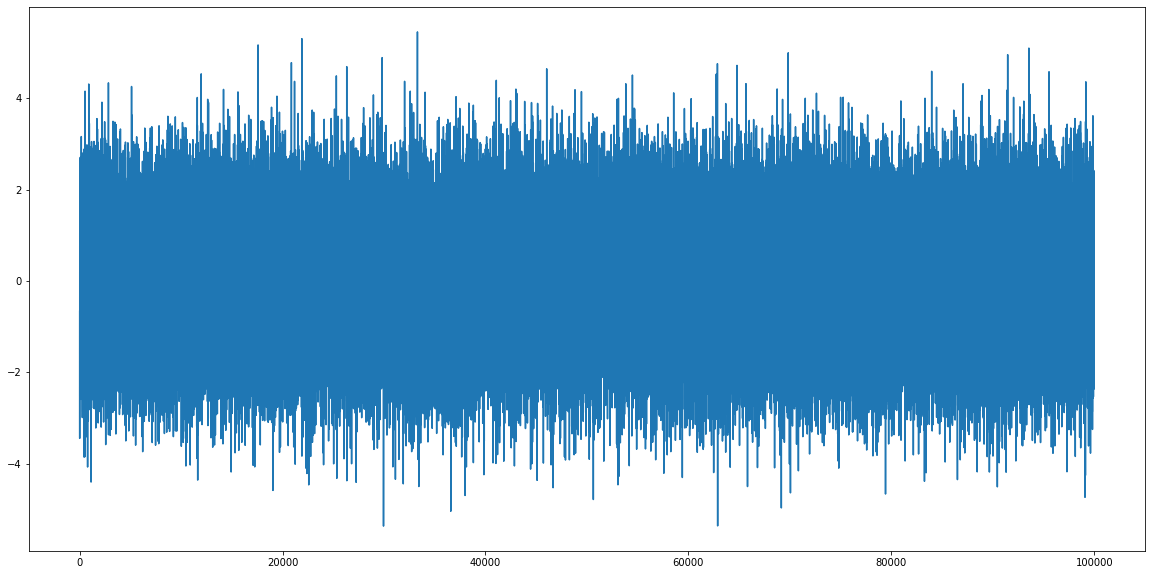

1 0


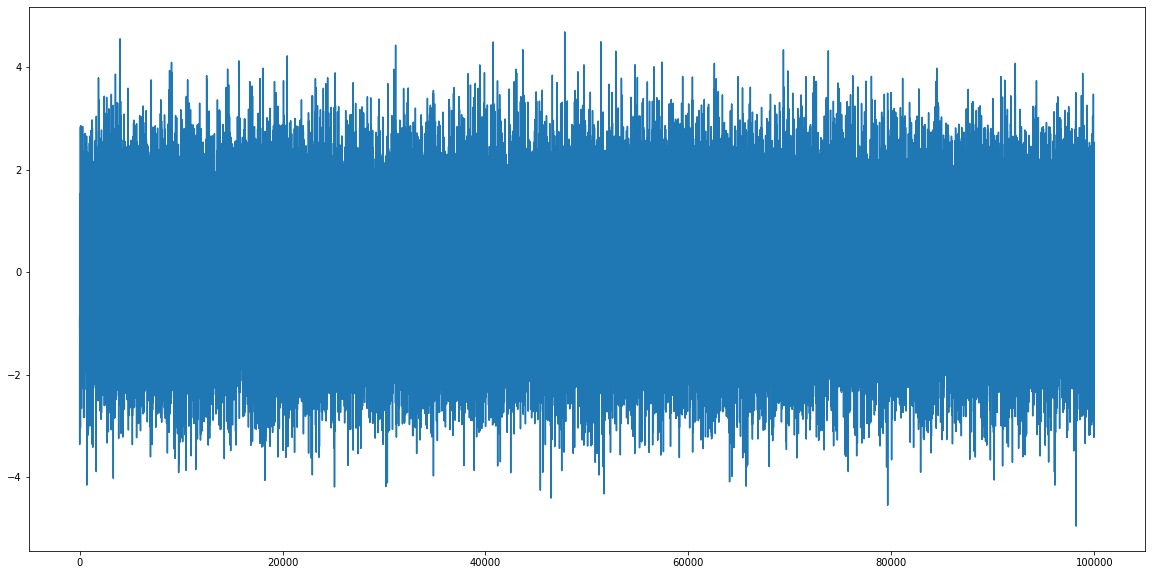

2 0


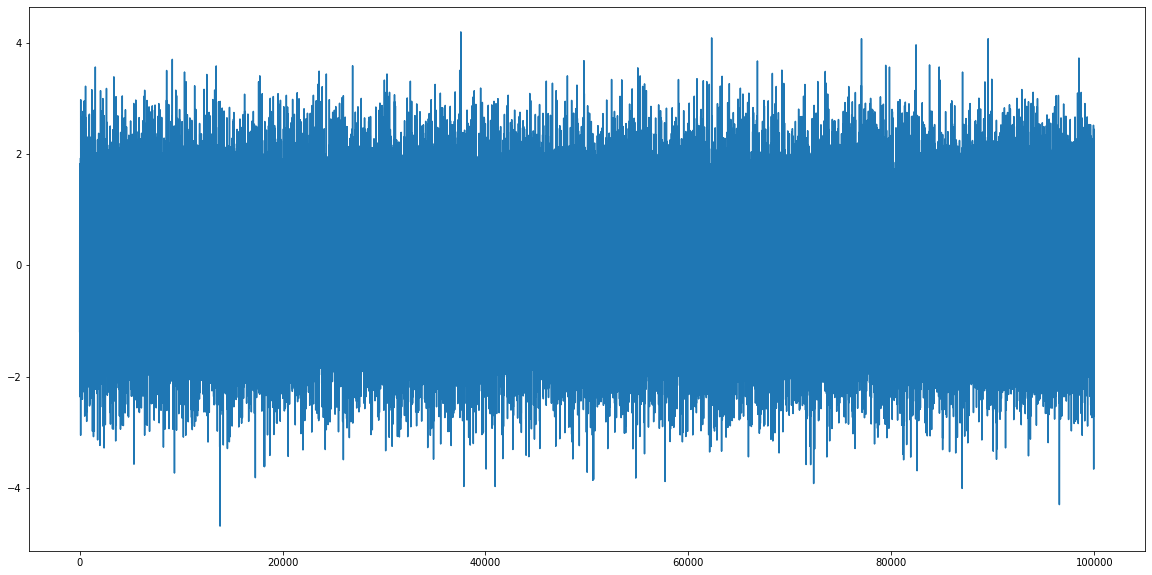

3 0


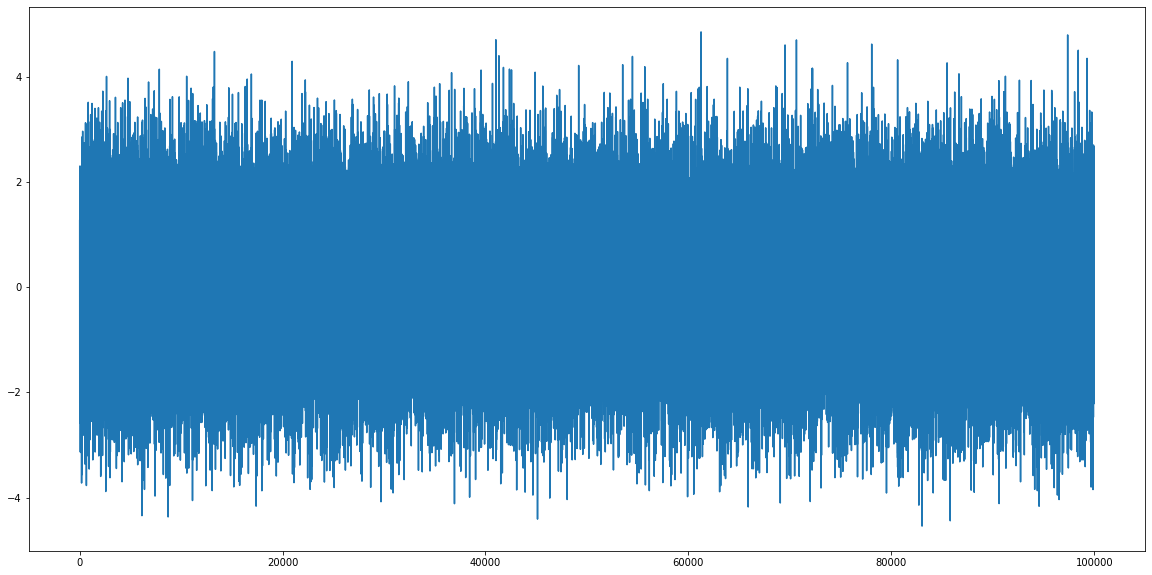

4 0


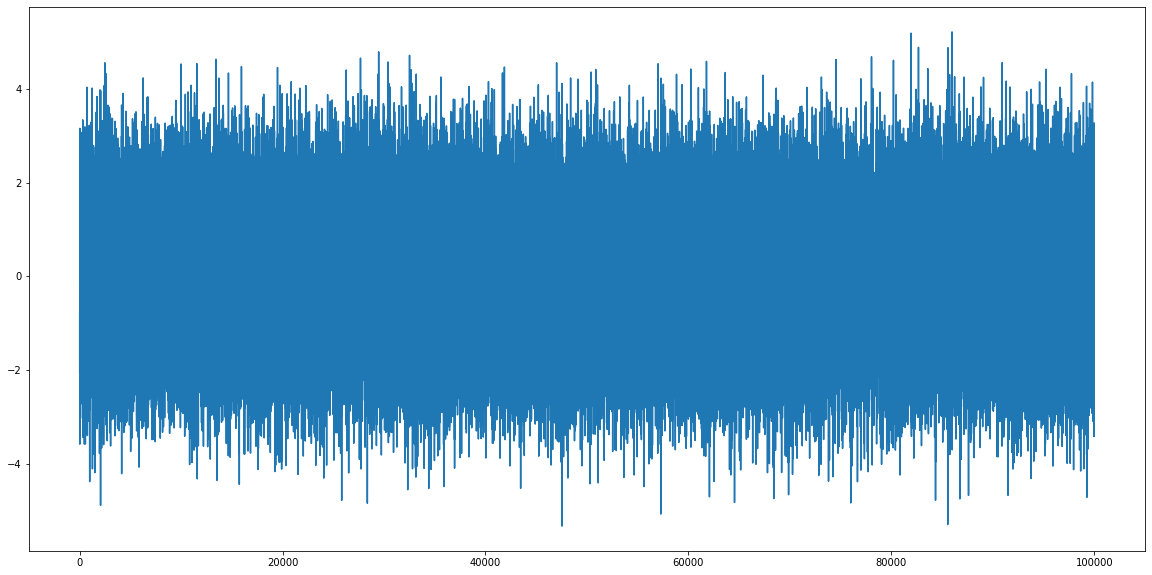

5 0


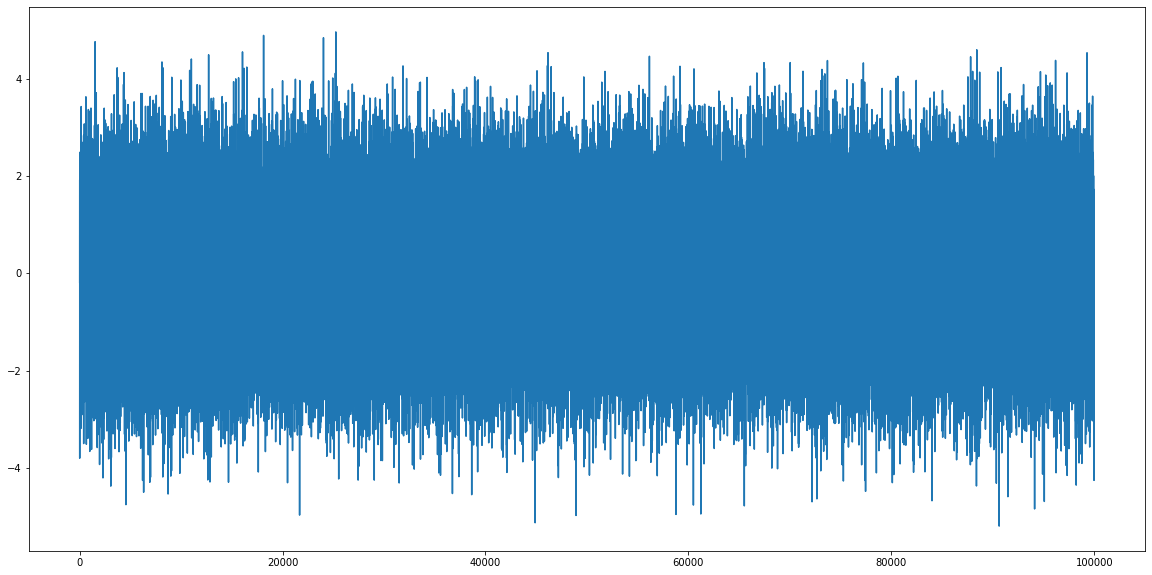

6 0


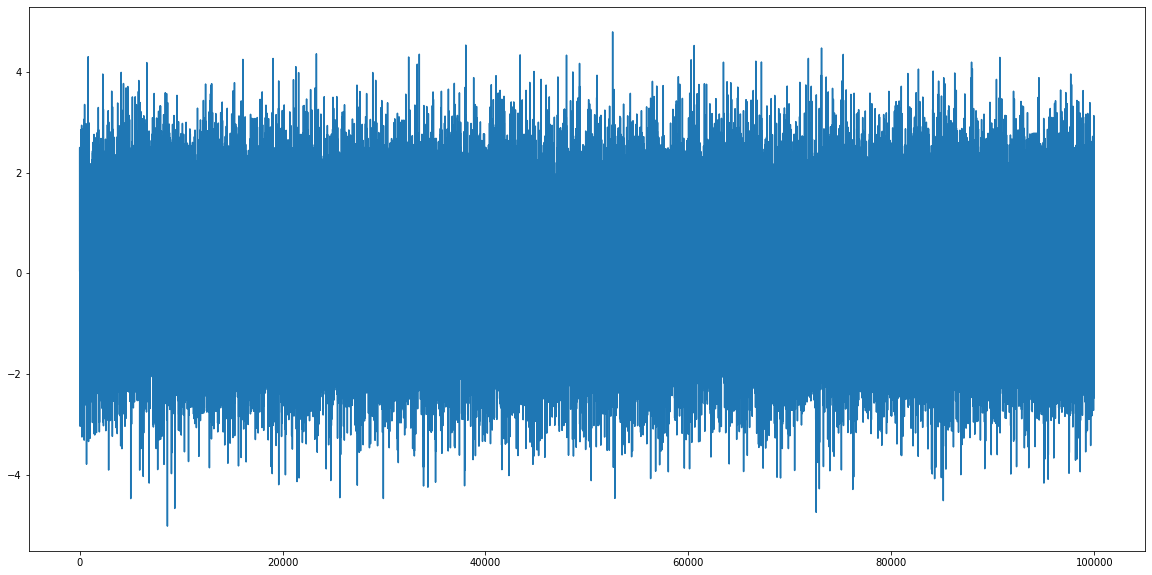

7 0


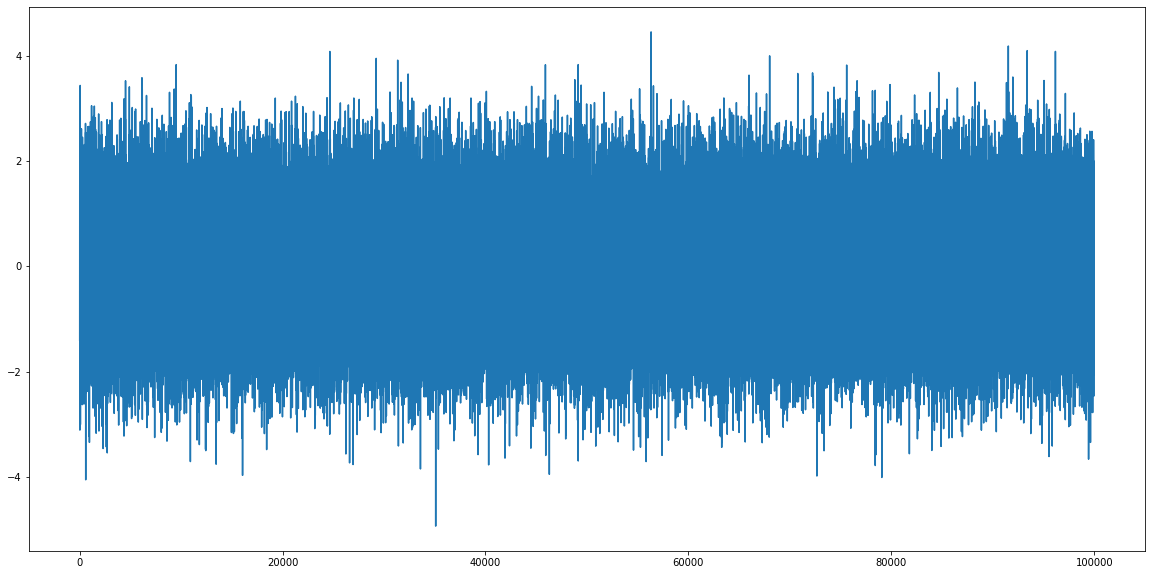

8 0


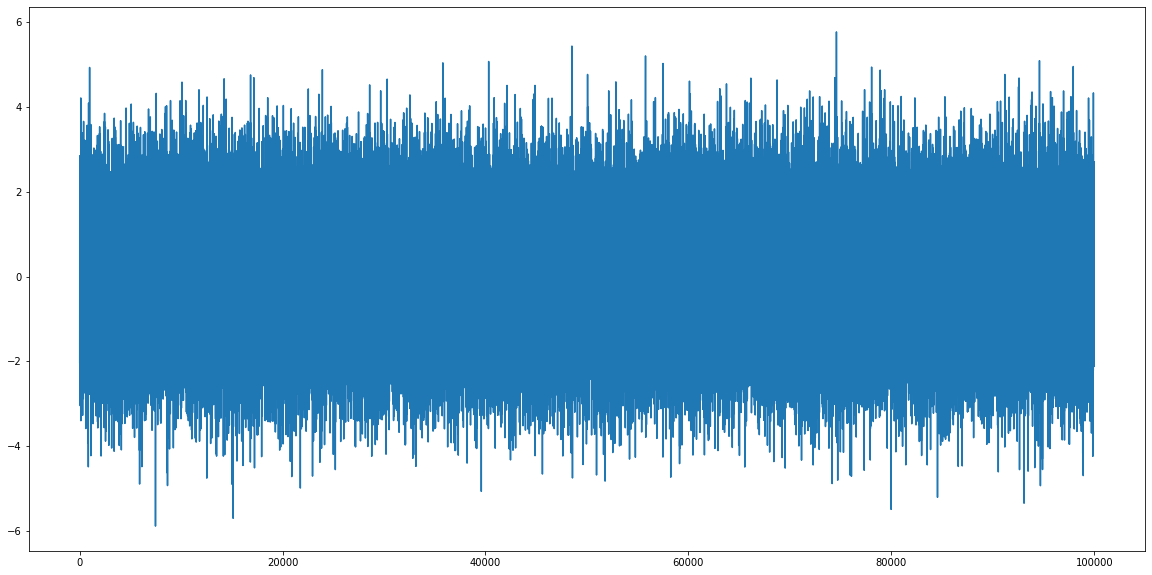

9 0


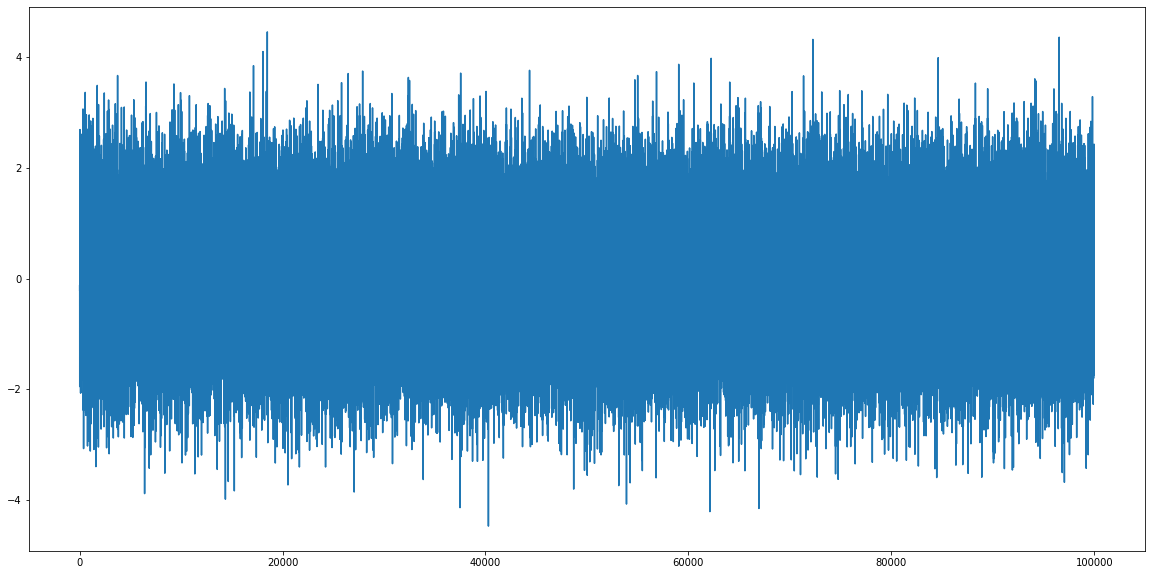

In [10]:
for i in range(len(Xs)):
    for j in range(Xs[i].shape[1]):
        plt.figure(figsize=(20, 10))
        print(i, j)
        plt.plot(Xs[i][:, j])
        plt.show()
        break

### Example of config 

In [11]:
print('Regressors')
print(configs[5][0])
print('Lags')
print(configs[5][1])
print('Signs')
print(configs[5][2])
print('Coefficients')
print(configs[5][3])

Regressors
{0: array([ 5, 11,  9, 14,  7,  1]), 1: array([2]), 2: array([3, 1, 0, 5]), 3: array([12,  5,  2]), 4: array([10,  0,  2, 12,  1,  8,  3, 14,  6]), 5: array([], dtype=int64), 6: array([ 3,  7,  5, 12,  0, 14,  4,  8,  2, 13]), 7: array([ 8,  2,  1,  3, 13]), 8: array([], dtype=int64), 9: array([ 1,  0,  6,  3, 12, 10,  4]), 10: array([ 0, 10,  4, 12]), 11: array([ 3, 14]), 12: array([ 5, 14,  0,  4,  2,  3, 12,  8]), 13: array([ 5,  1,  3, 11,  6,  7]), 14: array([ 7, 13,  4,  9,  5])}
Lags
{0: array([ 58, 106, 159,  97, 221, 204]), 1: array([97]), 2: array([125,  98, 150,  29]), 3: array([195, 210,  78]), 4: array([146, 117, 103, 207, 210, 112, 104,  42, 215]), 5: array([], dtype=int64), 6: array([223,  33,  47,  90,  56, 107, 197, 246, 108,  60]), 7: array([189, 106, 162, 139,  34]), 8: array([], dtype=int64), 9: array([ 64, 215, 171, 208, 168, 221,  28]), 10: array([151,  70, 236, 249]), 11: array([242, 245]), 12: array([249,  87,  93, 246,  89, 160, 128,   5]), 13: array

### Obtained equations

In [12]:
print("Equations obtained")
for k in range(len(configs)):
    print("Case ", k+1)
    for key in configs[k][0].keys():
        eq = "X{} = ".format(key)
        for  regr, ts, sign, coef in zip(configs[k][0][key], configs[k][1][key],
                                         configs[k][2][key], configs[k][3][key]):
            if(sign == 1):
                eq += "+"
            eq += str(sign*round(coef, 3)) + "X{}".format(regr) + "[t-{}]".format(ts) + " "
        eq += "+ n~N(0, 1)"
        print(eq)
        print("")

Equations obtained
Case  1
X0 = +0.129X7[t-249] -0.104X1[t-206] +0.374X4[t-55] -0.334X0[t-140] +0.341X2[t-89] + n~N(0, 1)

X1 = +0.235X1[t-182] +0.129X4[t-205] +0.149X2[t-122] -0.399X6[t-77] + n~N(0, 1)

X2 = -0.012X8[t-184] +0.106X7[t-200] + n~N(0, 1)

X3 = -0.312X6[t-140] -0.374X8[t-246] -0.035X9[t-136] -0.375X7[t-165] +0.072X1[t-60] -0.341X3[t-182] +0.209X4[t-174] +0.162X2[t-5] + n~N(0, 1)

X4 = -0.078X4[t-164] +0.201X3[t-213] -0.187X2[t-147] -0.037X1[t-89] + n~N(0, 1)

X5 = -0.239X8[t-78] -0.269X6[t-197] +0.254X5[t-187] +0.37X2[t-179] +0.1X1[t-69] +0.383X3[t-77] -0.073X9[t-84] +0.253X0[t-152] + n~N(0, 1)

X6 = +0.123X2[t-196] +0.241X5[t-152] + n~N(0, 1)

X7 = -0.267X6[t-221] -0.393X1[t-220] -0.286X4[t-151] -0.075X7[t-126] -0.256X9[t-247] +0.014X0[t-44] + n~N(0, 1)

X8 = +0.157X9[t-43] -0.185X3[t-73] +0.399X4[t-180] +0.199X7[t-131] -0.385X8[t-210] +0.355X0[t-21] + n~N(0, 1)

X9 = +0.103X2[t-86] +0.052X7[t-42] +0.126X1[t-2] + n~N(0, 1)

Case  2
X0 = -0.224X7[t-109] -0.353X1[t-124] +0

### Calculating dependencies for  randomly chosen targets

In [44]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
class TCNTemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation):
        super().__init__()
        padding = int(dilation*(kernel_size-1))
        self.pad = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation))
        self.residual = nn.Conv1d(input_channels, output_channels, 1)
        
    def forward(self, x):
        out = self.pad(x)
        out = torch.relu(self.conv1(out))
        out = self.pad(out)
        out = torch.relu(self.conv2(out))
        y = self.residual(x)
        out = torch.relu(out + y)
        return out
    

class TCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.first_layer = TCNTemporalBlock(input_dim, n_channels, kernel_size, 1)
        self.tcn_layers = nn.ModuleList([TCNTemporalBlock(n_channels, n_channels, kernel_size, 2**(i+1)) for i in range(n_layers-1)])
        self.n_layers = n_layers
        self.output_transform = nn.Linear(n_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.first_layer(x)
        for i in range(self.n_layers-1):
            x = self.tcn_layers[i](x)
        x = x[..., -1]
        out = self.output_transform(x)
        return out.squeeze(1)
    
class BidirectionalTCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.forward_tcn = TCN(input_dim, n_layers, n_channels, kernel_size)
        self.backward_tcn = TCN(input_dim, n_layers, n_channels, kernel_size)
        self.output_transform = nn.Linear(2, 1)
    def forward(self, x):
        y = torch.flip(x, (1,))
        out1 = self.forward_tcn(x)
        out2 = self.backward_tcn(y)
        out1 = out1.unsqueeze(1)
        out2 = out2.unsqueeze(1)
        out = torch.cat([out1, out2], dim=1)
        out = self.output_transform(out)
        
        return out.squeeze(1)

In [45]:
m = TCNTemporalBlock(32, 64, 3, 4)

In [46]:
x = torch.randn(8, 32, 10)

In [47]:
y = m(x)

In [48]:
y.shape

torch.Size([8, 64, 10])

In [49]:
m = BidirectionalTCN(5, 9)

In [50]:
x = torch.randn(8, 300, 5)

In [51]:
y = m(x)

In [52]:
y.shape

torch.Size([8])

In [53]:
depth = 300
epochs = 100
importance_calculation_steps = 20
early_stopping_epochs = 10

regularizer_coeff1 = 0.005
regularizer_coeff2 = 0.0001
scaling_coeff = 0.5
importance_lr = 0.1
importance_threshold = 0.005

In [54]:
maps = []
results = []

In [55]:
from tqdm import tqdm_notebook

In [57]:
for k in range(len(Xs)):
    print("Case: ", k+1)
    X = np.zeros((length, depth, Xs[k].shape[1]))
    for i in tqdm_notebook(range(Xs[k].shape[1])):
        for j in range(depth):
            X[:, j, i] = pd.Series(Xs[k][:, i]).shift(depth - j - 1).bfill()
    
    y = pd.Series(Xs[k][:, targets[k]]).shift(-1).ffill().values
    
    X_train = X[:train_length]
    X_test = X[train_length:]
    y_train = y[:train_length]
    y_test = y[train_length:]
    
    X_train_t = torch.Tensor(X_train)
    X_test_t = torch.Tensor(X_test)
    y_train_t = torch.Tensor(y_train)
    y_test_t = torch.Tensor(y_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)
    
    #model = TCNModel(X_train_t.shape[2], num_channels=[32] * 9, kernel_size=3, dropout=0.0).cuda()
    model = BidirectionalTCN(X_train_t.shape[2], 9).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.8)
    loss = nn.MSELoss()
    
    
    val_loss = 999
    counter = 0
    
    print("Training")
    for e in range(epochs):
        train_loss = 0
        model.train()
        for batch_x, batch_y in tqdm_notebook(train_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            output = model(batch_x)
            l = loss(output, batch_y)
            l.backward()
            opt.step()
            train_loss+=l.item()*batch_x.shape[0]
        true = []
        preds = []
        model.eval()
        sc.step()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.cuda()
                output = model(batch_x)
                true.append(batch_y.numpy())
                preds.append(output.detach().cpu().numpy())
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        mse = mean_squared_error(true, preds)
        r2 = r2_score(true, preds)
        print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
        if val_loss > mse:
            val_loss = mse
            torch.save(model.state_dict(), "tcn_bidir{}.pt".format(k))
        else:
            counter += 1
        
        if counter == early_stopping_epochs:
            break
    model.load_state_dict(torch.load('tcn_bidir{}.pt'.format(k)))
    
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()
    
    model.eval()
    
    print("Calculating Importance:")
    importance_map = []
    for batch_x, batch_y in tqdm_notebook(test_loader):
        batch_x = batch_x.cuda()
        #batch_y = batch_y.cuda()
        bx = batch_x
        y = model(batch_x)
        mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
        opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
        for e in range(importance_calculation_steps):
            opt.zero_grad()
            model.zero_grad()
            model.eval()
            y = y.detach()
            M = torch.sigmoid(mask)
            x_hat = bx*M
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff1*torch.sum(torch.abs(M))
            ones = torch.zeros_like(bx)
            ones[M>0.5] = 1
            l += 0.5*bce_loss(M, ones)
            l.backward()
            opt.step()
        M = torch.sigmoid(mask)
        #ms = ms.detach().cpu().numpy()
        thresholds = {}
        with torch.no_grad():
            for t in np.linspace(M.min().item(), M.max().item(), 100):
                M_clone = M.clone()
                M_clone[M_clone>t] = 1
                M_clone[M_clone<=t] = 0
                x_hat = bx*M_clone
                y_hat = model(x_hat)
                l = mse_loss(y_hat, y)
                l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
                thresholds[l.item()] = t
        t = thresholds[min(thresholds.keys())]
        M = M.detach().cpu().numpy()
        M[M>t] = 1
        M[M<=t] = 0
        importance_map.append(np.abs(M))
        
    importance_map = np.concatenate(importance_map)
    importance_map = np.mean(importance_map, axis=0)
    
    maps.append(importance_map)
    result = {}
    for i in range(importance_map.shape[1]):
        max_val = importance_map[:, i].max()
        if max_val > importance_threshold:
            timestep = importance_map.shape[0] - np.argmax(importance_map[:, i])
            result[i] = timestep
    
    FP, TP, FN = 0, 0, 0
    for regr, ts in zip(configs[k][0][targets[k]], configs[k][1][targets[k]]):
        predicted_timestep = result.get(regr)
        if predicted_timestep is None:
            FN += 1
        elif predicted_timestep != ts:
            FP += 1
            FN += 1
        else:
            TP += 1

    for regr in result.keys():
        if regr not in configs[k][0][targets[k]]:
            FP += 1
            
    precision = TP/(TP + FP + 1e-9)
    recall = TP/(TP + FN + 1e-9)
    print("Results: ", precision, recall)
    results.append([precision, recall])

Case:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.7269669836997985 mse:  1.4484801 r2:  0.2144136686675756


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.431370979976654 mse:  1.455456 r2:  0.21063024432697075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.4100992320537566 mse:  1.4446024 r2:  0.21651681502392217


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.3574280809879302 mse:  1.2644143 r2:  0.31424217767568696


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.183894263124466 mse:  1.1879998 r2:  0.3556857869039918


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1531079313278199 mse:  1.2121944 r2:  0.3425637244036054


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1444817635059357 mse:  1.1800747 r2:  0.359983879284972


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1353550678730011 mse:  1.1995289 r2:  0.3494329305956815


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.118901657819748 mse:  1.1732986 r2:  0.36365901302775205


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0991406114578246 mse:  1.1602954 r2:  0.3707113107235752


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0758123035907745 mse:  1.1637673 r2:  0.3688282966025521


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.062723191165924 mse:  1.1673169 r2:  0.3669031464849959


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0538412032604219 mse:  1.1675398 r2:  0.36678229298089227


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.0444905236244202 mse:  1.1793178 r2:  0.3603943961024221


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.0370873653411865 mse:  1.1826223 r2:  0.35860227071450734


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.0287499275684358 mse:  1.1883839 r2:  0.35547744740649856


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  1.0206576215267182 mse:  1.1883857 r2:  0.35547643563474507
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999998 0.624999999921875
Case:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1985359585762023 mse:  1.2114621 r2:  4.1594994460991686e-06


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.198195659351349 mse:  1.2117047 r2:  -0.000196113597608516


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.1978807606697082 mse:  1.2104465 r2:  0.000842388945864303


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.1852633316993713 mse:  1.1849673 r2:  0.02187412398724331


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1689687080860138 mse:  1.1803906 r2:  0.025651941450344107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.165603385591507 mse:  1.178024 r2:  0.0276053005368726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1618148631095886 mse:  1.1803793 r2:  0.025661276802738775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1518857576847077 mse:  1.1593409 r2:  0.04302740502652713


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.1326071533203126 mse:  1.1545417 r2:  0.046988811112632645


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.1251729383945466 mse:  1.1553109 r2:  0.04635394984226349


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.1174343070030213 mse:  1.1595542 r2:  0.04285122787611906


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.1120795149803162 mse:  1.1576428 r2:  0.044428982802114825


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.1062681576728821 mse:  1.1625584 r2:  0.040371423612616475


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.1002877686023713 mse:  1.1736637 r2:  0.031204589885751255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.093283089876175 mse:  1.1674806 r2:  0.03630849945453907


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.0861703842639923 mse:  1.1765532 r2:  0.028819460362633387


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  1.0788007713794707 mse:  1.1799561 r2:  0.02601062226845663
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.49999999975 0.3333333332222222
Case:  3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.5579792157649994 mse:  1.4838357 r2:  0.07760532765346628


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.4789136390209199 mse:  1.4760513 r2:  0.08244424197717193


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.4645963764190675 mse:  1.471763 r2:  0.08510999499106942


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.4478615765571594 mse:  1.4671472 r2:  0.08797928920466758


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.2490137400627137 mse:  1.2132227 r2:  0.24582598779823117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1732284502983092 mse:  1.2047733 r2:  0.2510783881535632


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1547099766254425 mse:  1.2168467 r2:  0.24357333092642908


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1377950462341309 mse:  1.200782 r2:  0.2535596256800643


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.107144760799408 mse:  1.190794 r2:  0.2597683423043332


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0785792616844176 mse:  1.2029293 r2:  0.25222479328944847


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0501574568986893 mse:  1.1764021 r2:  0.2687148608999992


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.0356809012889863 mse:  1.1784563 r2:  0.26743786800161073


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0246480082988738 mse:  1.1857443 r2:  0.26290743722696097


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.0129332987308501 mse:  1.2214055 r2:  0.24073935786671719


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  0.9996341157913208 mse:  1.2120267 r2:  0.24656953826523764


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  0.9927404960870743 mse:  1.2142324 r2:  0.24519839913629482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  0.9780081689596176 mse:  1.2279426 r2:  0.23667569751235484


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  17 train:  0.9681513621807099 mse:  1.2409624 r2:  0.22858230148125624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  18 train:  0.9574513167619705 mse:  1.229126 r2:  0.23594013976406447
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999998571428 0.49999999996428574
Case:  4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1249711184978486 mse:  1.090553 r2:  0.044439170043981124


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.0888754363059998 mse:  1.1079938 r2:  0.029157255236580637


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0840986998558044 mse:  1.0960021 r2:  0.03966462038517382


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0823899411201476 mse:  1.0903555 r2:  0.044612402082521374


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0783649798870087 mse:  1.078545 r2:  0.05496096323882804


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.07108454580307 mse:  1.080132 r2:  0.05357036520039815


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0659280718803406 mse:  1.078475 r2:  0.055022145101186526


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.0640840592384337 mse:  1.0795493 r2:  0.05408079483511197


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.0602137142658234 mse:  1.0803987 r2:  0.05333663905434771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0555567855834962 mse:  1.090995 r2:  0.04405199393069392


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0492452880859375 mse:  1.0799797 r2:  0.05370375864234911


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.044328633594513 mse:  1.0830867 r2:  0.05098134188254888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0389744243621826 mse:  1.0852861 r2:  0.04905412103598905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.0341688341617585 mse:  1.0860276 r2:  0.04840447416554472
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999989999999 0.3333333332222222
Case:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.0074621062755584 mse:  1.005344 r2:  -0.002508092386501737


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.001965388393402 mse:  1.0028585 r2:  -2.95620950654385e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0009719627380371 mse:  1.0032194 r2:  -0.0003893631908227224


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0002840868473053 mse:  1.0030797 r2:  -0.00025004877812939696


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  0.9989387658834458 mse:  1.0103657 r2:  -0.007515687407004368


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  0.9973068513393402 mse:  1.0063115 r2:  -0.0034728337535245846


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.9947628171920776 mse:  1.0092165 r2:  -0.006369613148959452


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9904403589248657 mse:  1.0098563 r2:  -0.007007600662163771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9849586404323578 mse:  1.0132059 r2:  -0.010347761970683989


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9782392438173294 mse:  1.024992 r2:  -0.0221005199780393


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.9672685035705566 mse:  1.0318763 r2:  -0.02896560212539323


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.957116632270813 mse:  1.0363616 r2:  -0.033438198837489885
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.0 0.0
Case:  6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.395106692123413 mse:  1.3855596 r2:  0.014129463404991771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.3313938148975373 mse:  1.3310877 r2:  0.052887856533862965


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.3095778499126434 mse:  1.3190467 r2:  0.061455385317814804


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.2716333611011505 mse:  1.271492 r2:  0.09529222508463775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1633137888908387 mse:  1.1725465 r2:  0.16569512478177228


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1375378979682922 mse:  1.177518 r2:  0.16215773780800735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1295783220767974 mse:  1.1674732 r2:  0.16930487808895855


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1234138856887816 mse:  1.1656005 r2:  0.1706373847808489


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.1188404397010803 mse:  1.1787341 r2:  0.16129237735809376


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.1129030940532685 mse:  1.171644 r2:  0.16633730639315425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.1019239444255828 mse:  1.1758085 r2:  0.16337407902115442


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.0897505969524384 mse:  1.1460985 r2:  0.18451377723522977


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0632136487483979 mse:  1.1384405 r2:  0.18996265092168108


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.0486341279506683 mse:  1.149254 r2:  0.1822684723614082


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.0408765466690064 mse:  1.1378646 r2:  0.19037228389391014


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.0311747639656066 mse:  1.1457953 r2:  0.1847294846159926


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  1.0241133952140808 mse:  1.1548601 r2:  0.1782794896802632


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  17 train:  1.0152687718391418 mse:  1.1537334 r2:  0.17908127861584622


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  18 train:  1.006981035900116 mse:  1.1618644 r2:  0.17329566226128057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  19 train:  0.9995841653823853 mse:  1.1682336 r2:  0.1687638838010881
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.7499999998125 0.59999999988
Case:  7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1265361505031586 mse:  1.0886872 r2:  0.031939640256815394


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.0448078814506532 mse:  1.0385654 r2:  0.07650792603335099


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0379438681602478 mse:  1.0420842 r2:  0.07337911138040942


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0344923417568206 mse:  1.0408938 r2:  0.07443762118534647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0336029891490937 mse:  1.0411258 r2:  0.074231353629298


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.0310743392944335 mse:  1.0398824 r2:  0.07533686753496827


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0279979459762574 mse:  1.02835 r2:  0.08559154137326574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.0082146769046783 mse:  1.0184296 r2:  0.09441265502319707


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.0009046747207642 mse:  1.0102162 r2:  0.10171611476784559


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.998036500787735 mse:  1.0186727 r2:  0.09419645665193077


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.9916680686235427 mse:  1.0131916 r2:  0.09907031627808671


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.986730652666092 mse:  1.0274601 r2:  0.08638277989677967


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.9824137626171112 mse:  1.0184374 r2:  0.09440574455364437


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  0.9764621286392212 mse:  1.0230108 r2:  0.09033903361765383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  0.970805182147026 mse:  1.0311741 r2:  0.08308027383651473
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999995 0.9999999995
Case:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.3284188882350922 mse:  1.1973275 r2:  0.25689156692188986


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.182548468351364 mse:  1.1672283 r2:  0.27557226794600476


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.167037249135971 mse:  1.1653981 r2:  0.2767080817429117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.161284273338318 mse:  1.1822375 r2:  0.266257028090641


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1505850428581237 mse:  1.1761117 r2:  0.2700588386295242


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1411244466781616 mse:  1.1767904 r2:  0.2696377055149308


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1355276041984559 mse:  1.1774763 r2:  0.2692119609245721


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1268705029964448 mse:  1.2020954 r2:  0.2539323453094362


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.1195230952262878 mse:  1.1840979 r2:  0.26510228237325073


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.108653625011444 mse:  1.1967163 r2:  0.25727087252455805


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0900920377254486 mse:  1.22347 r2:  0.2406665379201136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.0797473318576813 mse:  1.2159957 r2:  0.2453053347205364


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0684746780872345 mse:  1.2093785 r2:  0.24941220350612758
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.99999999975 0.4999999999375
Case:  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.62851458029747 mse:  1.446758 r2:  0.25841217122588833


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.4414323751449585 mse:  1.4686705 r2:  0.24718007705504474


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.4221117942810058 mse:  1.4405836 r2:  0.26157700848771304


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.4127931031227112 mse:  1.4380839 r2:  0.2628583190429733


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.4032931151866912 mse:  1.4360431 r2:  0.2639044008928705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.3914391760349274 mse:  1.4421207 r2:  0.26078913716675334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.3816652662754059 mse:  1.4622726 r2:  0.25045951683891565


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.3714829007148743 mse:  1.4706824 r2:  0.24614878098547


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.357071616077423 mse:  1.4740489 r2:  0.2444232346030566


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.3466000351905822 mse:  1.475176 r2:  0.24384543250618773


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.3221587170124054 mse:  1.4791123 r2:  0.24182773729787432


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.3074445504665375 mse:  1.4918989 r2:  0.23527349296280908


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.2947725086688995 mse:  1.4934429 r2:  0.23448210677618053


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.2825848559379578 mse:  1.5019777 r2:  0.23010726797796133
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999996666666 0.2727272727024793
Case:  10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.3443152561664582 mse:  1.3436936 r2:  -0.0007450341189019216


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.3443128161907196 mse:  1.3427376 r2:  -3.29148212403485e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.2070017322063447 mse:  1.1693501 r2:  0.12910107404111903


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.1635772937774658 mse:  1.1632166 r2:  0.13366911762666145


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1586591257095338 mse:  1.1605102 r2:  0.13568474250774776


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1566964584827424 mse:  1.1618611 r2:  0.1346786912496173


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1533969465732574 mse:  1.161388 r2:  0.13503097892678606


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.151570902633667 mse:  1.1593485 r2:  0.13655009125743844


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.1496509499073029 mse:  1.1615376 r2:  0.13491950325258395


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.1469445888996124 mse:  1.1638818 r2:  0.13317373716023828


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.1418673646450044 mse:  1.1646613 r2:  0.1325931128537302


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.1399987909793854 mse:  1.1642 r2:  0.13293669846048328


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.136122111225128 mse:  1.1697537 r2:  0.12880056508082605


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.1338114185333252 mse:  1.179409 r2:  0.12160942112747652


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.1305671063423157 mse:  1.1770875 r2:  0.12333842731433575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.127880025434494 mse:  1.1726958 r2:  0.12660927808153977
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999989999999 0.2499999999375


In [59]:
for i, r in enumerate(results):
    print('Case {}'.format(i+1))
    print('Precision', 'Recall')
    print(r)

Case 1
Precision Recall
[0.9999999998, 0.624999999921875]
Case 2
Precision Recall
[0.49999999975, 0.3333333332222222]
Case 3
Precision Recall
[0.9999999998571428, 0.49999999996428574]
Case 4
Precision Recall
[0.9999999989999999, 0.3333333332222222]
Case 5
Precision Recall
[0.0, 0.0]
Case 6
Precision Recall
[0.7499999998125, 0.59999999988]
Case 7
Precision Recall
[0.9999999995, 0.9999999995]
Case 8
Precision Recall
[0.99999999975, 0.4999999999375]
Case 9
Precision Recall
[0.9999999996666666, 0.2727272727024793]
Case 10
Precision Recall
[0.9999999989999999, 0.2499999999375]


### Visual estimation of resulted importance heatmaps

Case 1


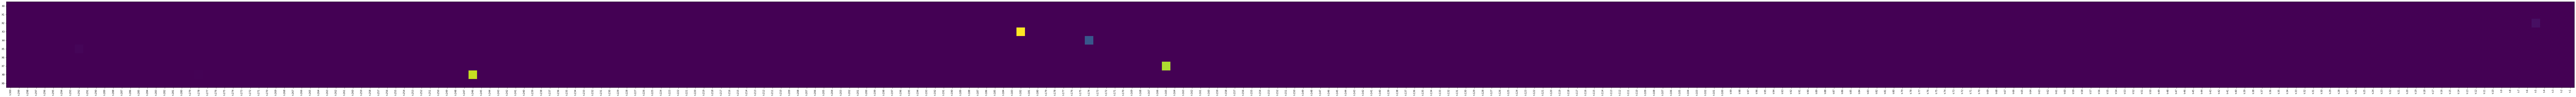

Case 2


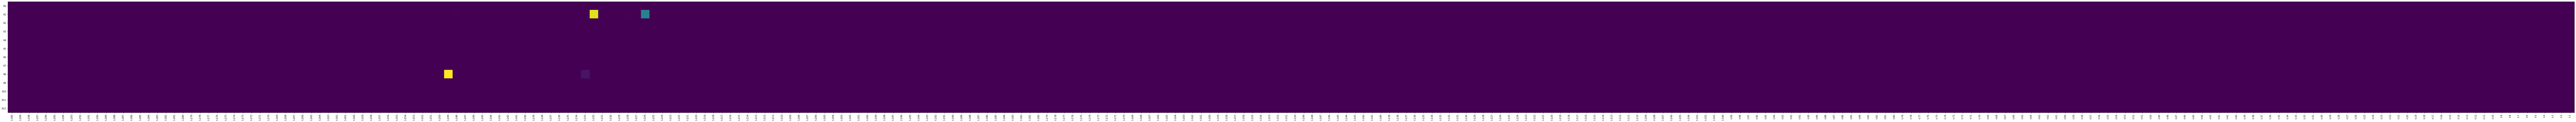

Case 3


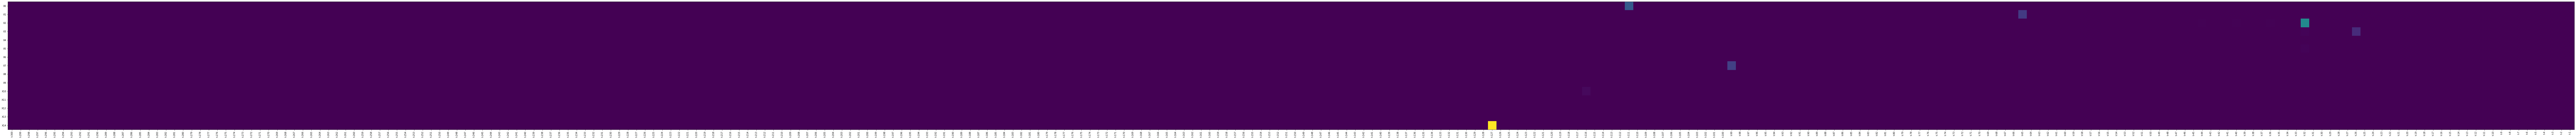

Case 4


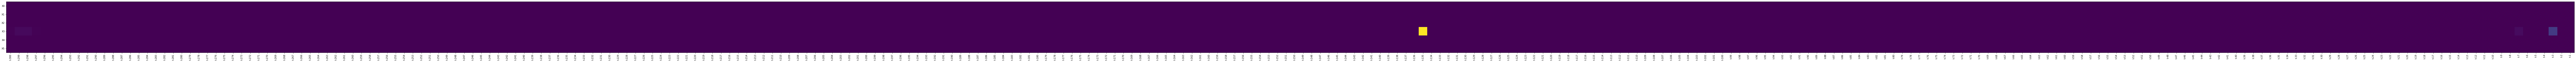

Case 5


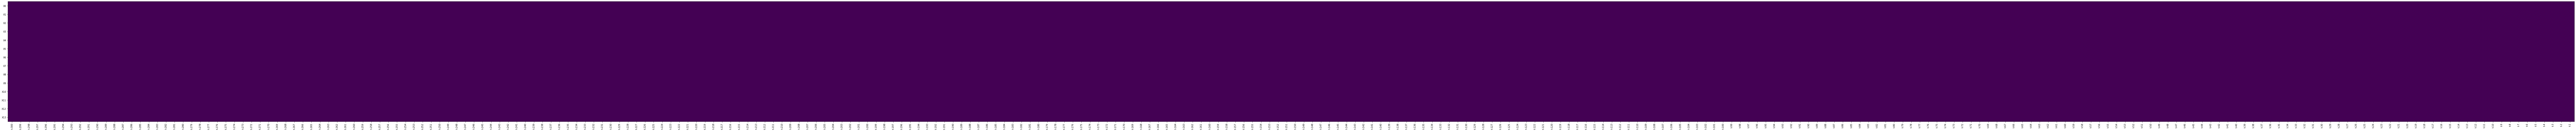

Case 6


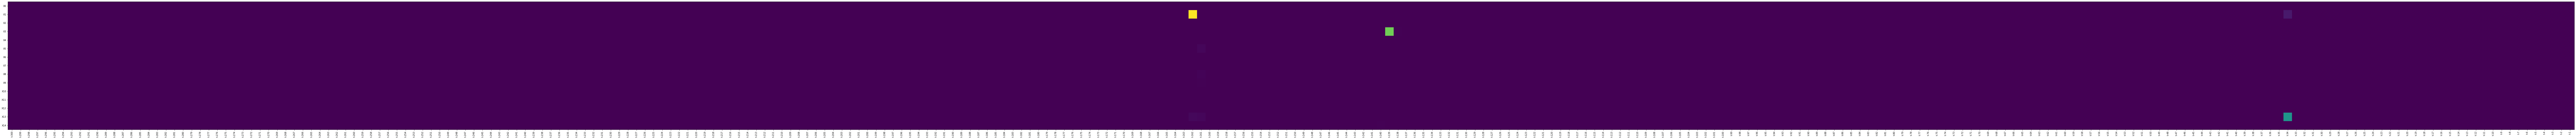

Case 7


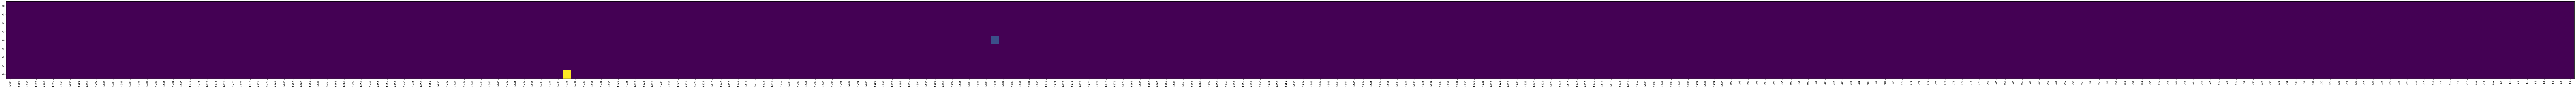

Case 8


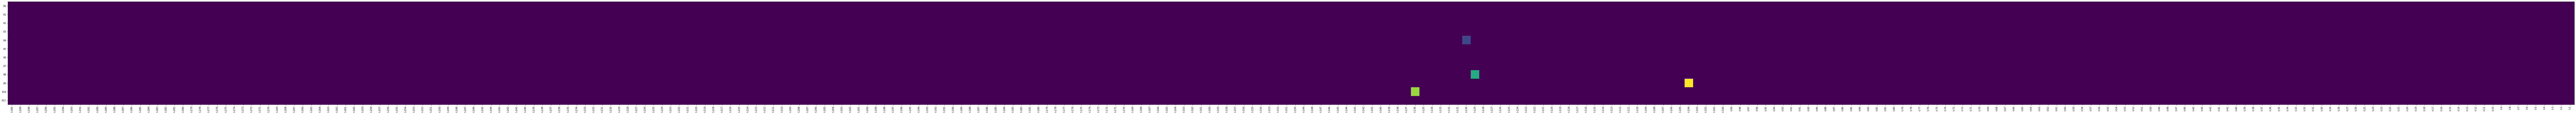

Case 9


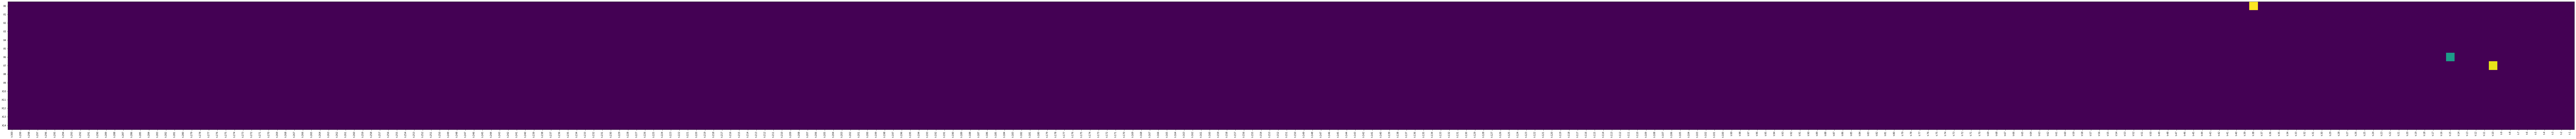

Case 10


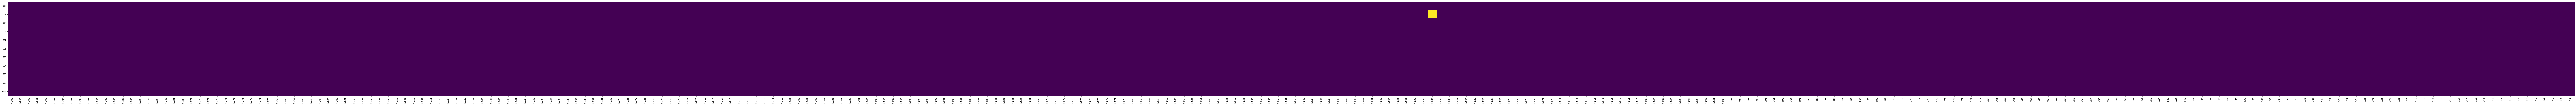

In [60]:
for i in range(number_of_experiments):
    print('Case {}'.format(i+1))
    fig, ax = plt.subplots(figsize=(200, 100))
    ax.imshow(maps[i].T)
    ax.set_xticks(np.arange(depth))
    ax.set_xticklabels(["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
    ax.set_yticks(np.arange(Xs[i].shape[1]))
    ax.set_yticklabels(["X{}".format(i) for i in range(Xs[i].shape[1])])
    plt.show()